# Fitting weighted histograms with SPD method

We test different fit methods of weighted binned data. The tested weight distributions are normal, exponential, and uniform. The toy case is a common HEP fit of a gaussian peak above a smooth background (here exponential). 

Fits of weighted data are discussed in F. James, "Statistical Methods in Experimental Physics" (2nd edition), World Scientific, in section 8.5. Two approximate least-squares methods for binned data are presented in section 8.5.4. Here we test the method $Q_1'$.

[Bohm and Zech (2014)](https://arxiv.org/abs/1309.1287) derived an approximate maximum-likelihood method for weighted histograms with on average positive weights. The authors show that their approximation yields less biased results than the aforementioned least-squares method. 

Still, a notable bias is present even when the SPD method is used. The largest bias is found for exponentially distributed weights with deviations of 4-5% in the fitted parameters.

The remaining bias of the SPD method originates from the fact that the true weight variance in each bin is unknown and is replaced by the sample variance. This is inaccurate in bins with small number of samples and fails for empty bins, which must be skipped. The same is true for the alternative least-squares fit, however, and the biases are even larger there.

The study suggest that biases are larger if the weight distribution deviates more from the normal distribution.

In [61]:
#!pip install boost-histogram iminuit scipy matplotlib numpy numba progressbar2 pyik
import boost_histogram as bh
from iminuit import Minuit
from scipy.stats import norm, expon, uniform, poisson
from multiprocessing.pool import Pool
from matplotlib import pyplot as plt
from pyik.mplext import plot_stacked
import numpy as np
import numba as nb
from progressbar import progressbar

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 1:03:32 Time:  1:03:32
100% (10000 of 10000) |##################| Elapsed Time: 1:03:52 Time:  1:03:52
100% (10000 of 10000) |##################| Elapsed Time: 1:04:05 Time:  1:04:05
100% (10000 of 10000) |##################| Elapsed Time: 1:04:19 Time:  1:04:19
100% (10000 of 10000) |##################| Elapsed Time: 1:04:47 Time:  1:04:47


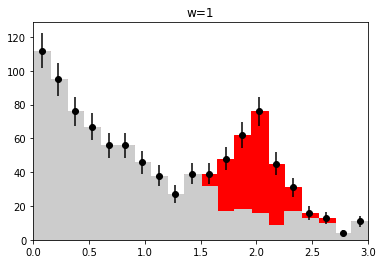

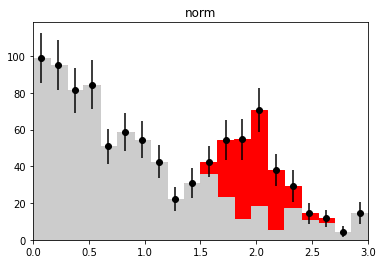

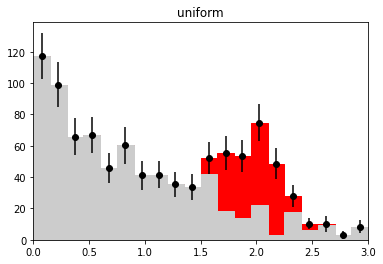

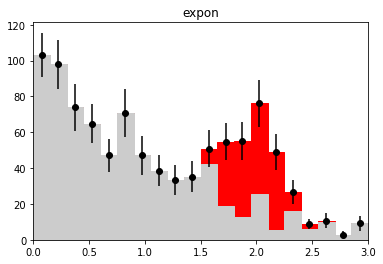

In [65]:
@nb.njit
def cost_lsq(n, mu):
    r = 0.0
    for i in range(len(mu)):
        if n[i] == 0: continue
        r += (n[i] - mu[i]) ** 2 / n[i]
    return r


@nb.njit
def _cost_lsq_w(w, wvar, mu):
    r = 0.0
    for i in range(len(mu)):
        if wvar[i] == 0: continue
        r += (w[i] - mu[i]) ** 2 / wvar[i]
    return r


def cost_lsq_w(w, mu):
    return _cost_lsq_w(w.value, w.variance, mu)


@nb.njit
def cost_ml(n, mu):
    r = 0.0
    for i in range(len(mu)):
        r += mu[i] - n[i] * np.log(mu[i])
    return 2 * r


@nb.njit
def _cost_ml_w(w, wvar, mu):
    # Bohm and Zech, NIMA 748 (2014) 1-6
    r = 0.0
    for i in range(len(mu)):
        if wvar[i] > 0.0:
            if w[i] > 0.0:
                s_inv = w[i] / wvar[i]
                mu_prime = mu[i] * s_inv
                n_prime = w[i] * s_inv        
                r += mu_prime - n_prime * np.log(mu_prime)
            else: # extension
                r += 0.5 * (w[i] - mu[i]) ** 2 / wvar[i]
    return 2 * r


def cost_ml_w(w, mu):
    return _cost_ml_w(w.value, w.variance, mu)


weight_distributions = [None, np.ones, norm().rvs, uniform().rvs, expon().rvs]
wd_labels = ("no weights","w=1", "norm", "uniform", "expon")

mu_npts = 1000
signal_fraction = 0.2

par_labels = ("bkg: fraction", "sig: fraction", "bkg: lambda", "sig: mu", "sig: sigma")
truth = ((1.0 - signal_fraction), signal_fraction, 1.0, 2.0, 0.2)

def run(args):
    wd, wd_label = args
    rng = np.random.seed(1)
    sub_pars = []
    for imc in progressbar(range(nmc), redirect_stdout=True):
        # sample total number of points from poisson distribution
        npts = poisson(mu_npts).rvs()
        
        # generate background
        b = expon(scale=truth[2]).rvs(int(truth[0] * npts))
        
        # generate signal
        s = norm(truth[3], truth[4]).rvs(int(truth[1] * npts))
        x = np.append(b, s)

        if wd is None:
            h = bh.Histogram(bh.axis.Regular(20, 0, 3))
            h.fill(x)
            xe = h.axes[0].edges
            w = h.view()

        else:
            # generate weights
            wi = wd(len(x))
            if np.std(wi) > 0:
                wi = (wi - np.mean(wi)) / np.std(wi) + 1.0 # wi have mean(wi) = 1 and std(wi) = 1
            h = bh.Histogram(bh.axis.Regular(20, 0, 3), storage=bh.storage.Weight())
            h.fill(x, weight=wi)
            xe = h.axes[0].edges
            w = h.view()

        sub_sub_pars = []
        for fit_mode in range(2):
            if wd is None:
                if fit_mode == 0:
                    cost = cost_lsq
                else:
                    cost = cost_ml
            else:
                if fit_mode == 0:
                    cost = cost_lsq_w
                else:
                    cost = cost_ml_w

            def nll(par):
                bkg = expon(scale=par[2]).cdf(xe)
                sig = norm(par[3], par[4]).cdf(xe)
                mu_bkg = par[0] * npts * (bkg[1:] - bkg[:-1])
                mu_sig = par[1] * npts * (sig[1:] - sig[:-1])
                res = cost(w, mu_bkg + mu_sig)
                return res

            m = Minuit.from_array_func(
                nll,
                truth,
                limit=((0.0, None), (0.0, None), (0.0, None), None, (0.0, None)),
                pedantic=False,
            )

            m.migrad()
            assert m.migrad_ok()
            sub_sub_pars.append(m.np_values())
            
        if nmc == 1 and wd is not None:
            plt.figure()
            h_bkg = bh.Histogram(h.axes[0], storage=bh.storage.Weight())
            h_bkg.fill(x[:len(b)], weight=wi[:len(b)])
            h_sig = bh.Histogram(h.axes[0], storage=bh.storage.Weight())
            h_sig.fill(x[len(b):], weight=wi[len(b):])
            plot_stacked(xe, np.array((h_bkg.view().value, h_sig.view().value)), colors=("0.8", "r"), labels=("bkg", "sig"))
            plt.errorbar(h.axes[0].centers, w.value, w.variance ** 0.5, fmt="ok")
            plt.title(wd_label)
            plt.ylim(0, None)
            plt.xlim(xe[0], xe[-1])

        sub_pars.append(sub_sub_pars)
    return sub_pars

# for drawing examples
nmc = 1
for args in zip(weight_distributions, wd_labels):
    run(args)

nmc = 10000
p = Pool()
pars = p.map(run, zip(weight_distributions, wd_labels))
pars = np.array(pars)

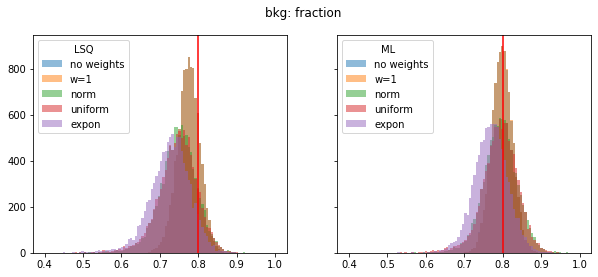

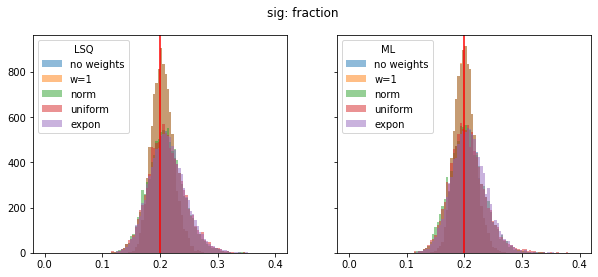

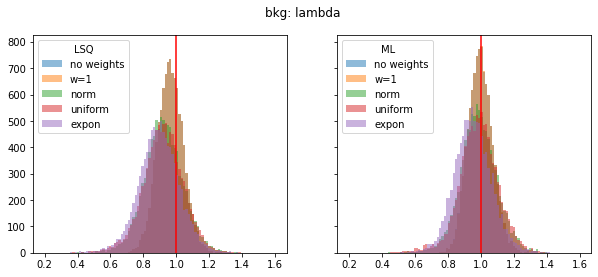

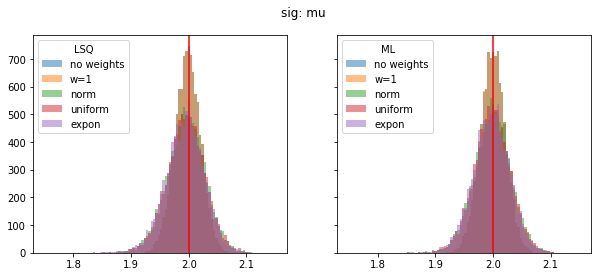

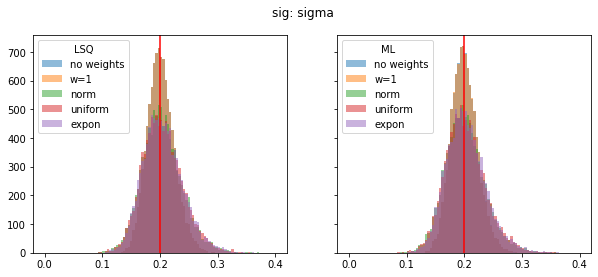

In [66]:
fit_labels = ("LSQ", "ML")
pars_range = ((0.4, 1.0), (0.0, 0.4), (0.2, 1.6), (1.75, 2.15), (0.0, 0.4))
for ipar, (par_label, t) in enumerate(zip(par_labels, truth)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    plt.suptitle(par_label)
    for iwd, wd_label in enumerate(wd_labels):
        for ifit, fit_label in enumerate(fit_labels):
            plt.sca(ax[ifit])
            p = pars[iwd, :, ifit, ipar]
            plt.hist(p, alpha=0.5, label=wd_label,
                     bins=100, range=pars_range[ipar])
    for label, axi in zip(fit_labels, ax):
        axi.axvline(t, color="r")
        axi.legend(loc="upper left", title=label)

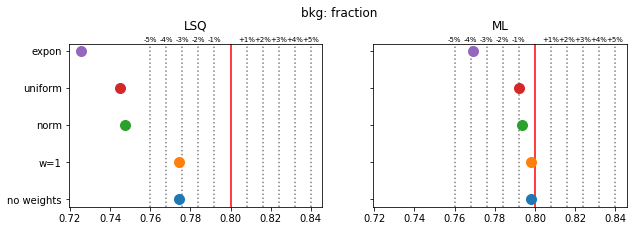

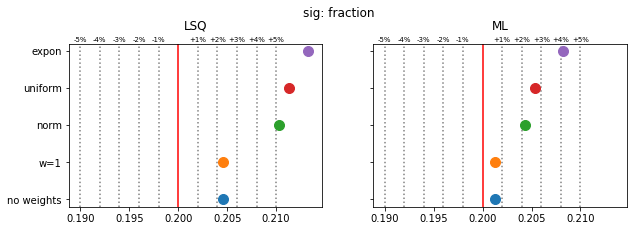

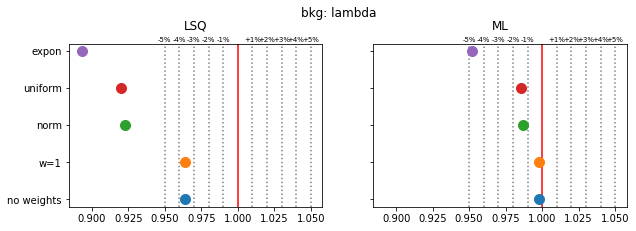

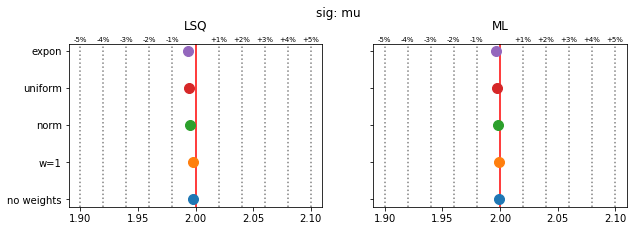

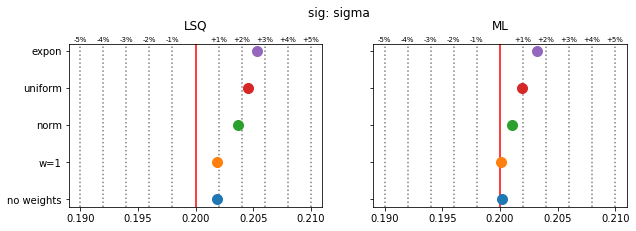

In [67]:
for ipar, (par_label, t) in enumerate(zip(par_labels, truth)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    plt.suptitle(f"{par_label}", y=1.05)
    for iwd, wd_label in enumerate(wd_labels):
        for ifit in range(2):
            plt.sca(ax[ifit])
            p = pars[iwd, :, ifit, ipar]
            mean = np.mean(p)
            sigma = np.std(p) / len(p) ** 0.5
            plt.errorbar(mean, iwd, 0, sigma, fmt="o", ms=10)
    for fit_label, axi in zip(fit_labels, ax):
        axi.set_title(fit_label, y=1.05)
        axi.axvline(t, color="r")
        for percent in (1, 2, 3, 4, 5):
            dt = t * 1e-2 * percent
            axi.axvline(t - dt, color="0.5", ls=":")
            axi.axvline(t + dt, color="0.5", ls=":")
            axi.text(t + dt, 1.01, f"+{percent}%", transform=axi.get_xaxis_transform(),
                     ha="center", fontsize="x-small")
            axi.text(t - dt, 1.01, f"-{percent}%", transform=axi.get_xaxis_transform(),
                     ha="center", fontsize="x-small")
    plt.sca(ax[0])
    plt.yticks(np.arange(len(wd_labels)), wd_labels)